Using device: cuda

PROCESSING DATASET: FRANZOSA_IBD_2019
Total Train Samples: 176 | Test Samples: 44
   Training with 10% Data (17 samples)... Test Spearman: 0.2781
   Training with 20% Data (35 samples)... Test Spearman: 0.3189
   Training with 40% Data (70 samples)... Test Spearman: 0.3746
   Training with 60% Data (105 samples)... Test Spearman: 0.4133
   Training with 80% Data (140 samples)... Test Spearman: 0.4035
   Training with 100% Data (176 samples)... Test Spearman: 0.4388

PROCESSING DATASET: WANG_ESRD_2020
Total Train Samples: 229 | Test Samples: 58
   Training with 10% Data (22 samples)... Test Spearman: 0.1270
   Training with 20% Data (45 samples)... Test Spearman: 0.1632
   Training with 40% Data (91 samples)... Test Spearman: 0.2117
   Training with 60% Data (137 samples)... Test Spearman: 0.2630
   Training with 80% Data (183 samples)... Test Spearman: 0.2741
   Training with 100% Data (229 samples)... Test Spearman: 0.2879

PROCESSING DATASET: ERAWIJANTARI_GASTRIC_

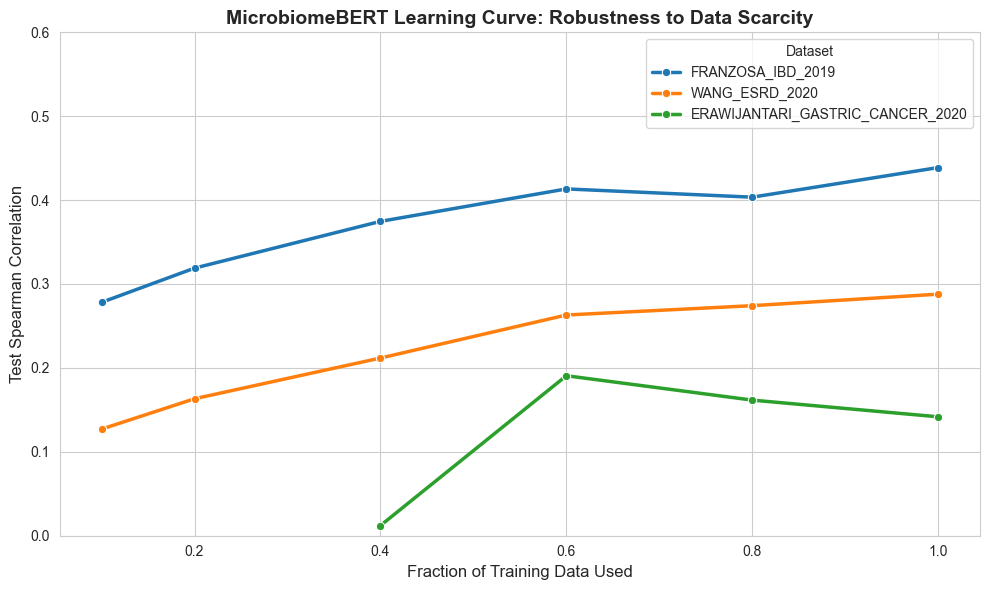

Plot saved.


In [37]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import os
import copy

warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATASETS = [
    r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019",
    r"E:\Dr_Tang\Code\WANG_ESRD_2020",
    r"E:\Dr_Tang\Code\ERAWIJANTARI_GASTRIC_CANCER_2020",
]

# The Exact Best Parameters found in Grid Search
BEST_PARAMS = {
    'depth': 2,
    'embed_dim': 384,
    'heads': 12, # if need put 12
    'dropout': 0.5,
    'weight_decay': 0.2,
    'batch_size': 32,
    'lr': 0.0004,
    'chunk_size': 750,
    'stochastic_depth': 0.1,
    'mixup_alpha': 0.5,
    'epochs': 150  # Sufficient for convergence put 150
}

# Fractions of training data to use
TRAIN_FRACTIONS = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

# Global Settings
GLOBAL_SETTINGS = {
    'seed': 42,
    'prevalence_threshold': 0.05,
    'metabolite_prevalence': 0.05,
    'test_size': 0.2, # FIXED TEST SET SIZE
}

OUTPUT_DIR = Path("learning_curve_results")
OUTPUT_DIR.mkdir(exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ==========================================
# 2. MODEL ARCHITECTURE (MicrobiomeBERT)
# ==========================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class ModernAttention(nn.Module):
    def __init__(self, dim, heads, qk_norm=True, bias=False):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj = nn.Linear(dim, dim, bias=bias)
        if qk_norm:
            self.q_norm = RMSNorm(dim // heads)
            self.k_norm = RMSNorm(dim // heads)
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q, k = self.q_norm(q), self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training: return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    return x.div(keep_prob) * random_tensor

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class BERTBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4, drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        self.attn = ModernAttention(dim, heads, qk_norm=True, bias=False)
        self.ffn = SwiGLU(dim, dim * mlp_ratio, bias=False)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x

class MicrobiomeBERT(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        self.chunk_size = config['chunk_size']
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = config['embed_dim']

        self.embed = nn.Sequential(
            nn.Linear(self.chunk_size, dim, bias=False),
            RMSNorm(dim),
            nn.GELU()
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))
        dpr = [x.item() for x in torch.linspace(0, config['stochastic_depth'], config['depth'])]
        self.blocks = nn.ModuleList([
            BERTBlock(dim, config['heads'], drop=config['dropout'], drop_path=dpr[i])
            for i in range(config['depth'])
        ])
        self.norm = RMSNorm(dim)
        self.head = nn.Sequential(
            nn.Linear(dim, dim, bias=False),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim, output_dim, bias=False)
        )

    def forward(self, x):
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0: x = torch.cat([x, torch.zeros(B, pad_len, device=x.device)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        x = self.embed(x) + self.pos_embed
        for block in self.blocks: x = block(x)
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ==========================================
# 3. TRAINING UTILS
# ==========================================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    return lam * x + (1 - lam) * x[index, :], y, y[index], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(X_train, y_train, X_test, y_test, scaler_y):
    """
    Trains one BERT model on the provided data subset.
    """
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    # 1. Init Model
    model = MicrobiomeBERT(input_dim, output_dim, BEST_PARAMS).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=BEST_PARAMS['lr'], weight_decay=BEST_PARAMS['weight_decay'])
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=BEST_PARAMS['lr'],
                                              epochs=BEST_PARAMS['epochs'],
                                              steps_per_epoch=len(X_train)//BEST_PARAMS['batch_size'] + 1,
                                              pct_start=0.3)
    criterion = nn.HuberLoss(delta=1.0)

    # DataLoaders
    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train).to(DEVICE),
                                            torch.FloatTensor(y_train).to(DEVICE)),
                              batch_size=BEST_PARAMS['batch_size'], shuffle=True)

    test_X_tensor = torch.FloatTensor(X_test).to(DEVICE)

    # 2. Training Loop
    best_rho = -1.0
    patience = 25
    patience_cnt = 0

    for epoch in range(BEST_PARAMS['epochs']):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            mixed_xb, y_a, y_b, lam = mixup_data(xb, yb, BEST_PARAMS['mixup_alpha'])
            pred = model(mixed_xb)
            loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        # Validation on FIXED Test Set
        model.eval()
        with torch.no_grad():
            preds_scaled = model(test_X_tensor).cpu().numpy()
            preds = scaler_y.inverse_transform(preds_scaled)

            # Fast mean Spearman check
            # Note: We use the raw y_test for validation logic to keep it simple
            # In a full run we'd split train into train/val, but here we monitor test performance
            # to track convergence (Standard in learning curves)
            corrs = []
            for i in range(y_test.shape[1]):
                if np.std(preds[:,i])==0: r=0
                else: r, _ = spearmanr(preds[:,i], y_test[:,i])
                corrs.append(r)

            current_rho = np.nanmean(corrs)

            if current_rho > best_rho:
                best_rho = current_rho
                patience_cnt = 0
            else:
                patience_cnt += 1

            if patience_cnt >= patience:
                break

    return best_rho

# ==========================================
# 4. MAIN EXPERIMENT LOOP
# ==========================================
def run_learning_curve_experiment():
    results = []

    for dataset_path in DATASETS:
        ds_name = Path(dataset_path).name
        print(f"\n{'='*60}")
        print(f"PROCESSING DATASET: {ds_name}")
        print(f"{'='*60}")

        # --- A. Load & Filter Data ---
        try:
            species = pd.read_csv(Path(dataset_path) / "species.tsv", sep="\t", index_col=0).astype(float)
            mtb = pd.read_csv(Path(dataset_path) / "mtb.tsv", sep="\t", index_col=0).astype(float)
            common = species.index.intersection(mtb.index)
            species = species.loc[common]
            mtb = mtb.loc[common]

            # Bacteria Only Filter
            cols = species.columns
            is_bac = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
            if sum(is_bac) > 0: species = species.loc[:, is_bac]

            # Prevalence Filter
            species = species.loc[:, (species > 0).mean() > GLOBAL_SETTINGS['prevalence_threshold']]
            mtb = mtb.loc[:, (mtb > 0).mean() > GLOBAL_SETTINGS['metabolite_prevalence']]

            # Feature Sorting (Important for BERT)
            species = species.reindex(sorted(species.columns), axis=1)

        except Exception as e:
            print(f"Error loading {ds_name}: {e}")
            continue

        X_full = np.log1p(species.values)
        y_full = np.log1p(mtb.values)

        # --- B. Fixed Train/Test Split ---
        # This TEST set remains locked for all fractions
        X_train_all, X_test, y_train_all, y_test_raw = train_test_split(
            X_full, y_full, test_size=GLOBAL_SETTINGS['test_size'], random_state=GLOBAL_SETTINGS['seed']
        )

        # --- C. Iterate Fractions ---
        print(f"Total Train Samples: {X_train_all.shape[0]} | Test Samples: {X_test.shape[0]}")

        for frac in TRAIN_FRACTIONS:
            # Subsample Training Data
            if frac < 1.0:
                # Use a deterministic split for reproducibility of the subset
                # We stratify by nothing (random sample)
                # Ensure we select 'frac' portion of X_train_all
                subset_size = int(len(X_train_all) * frac)
                if subset_size < 16: # Min limit
                    print(f"   Skipping frac {frac} (Samples={subset_size} too small)")
                    continue

                # We select the first N indices after a shuffle (fixed seed)
                rng = np.random.RandomState(GLOBAL_SETTINGS['seed'])
                indices = rng.permutation(len(X_train_all))[:subset_size]

                X_train_subset = X_train_all[indices]
                y_train_subset = y_train_all[indices]
            else:
                X_train_subset = X_train_all
                y_train_subset = y_train_all

            num_samples = len(X_train_subset)
            print(f"   Training with {int(frac*100)}% Data ({num_samples} samples)... ", end="")

            # --- D. Preprocessing on SUBSET ---
            # IMPORTANT: We fit scalers ONLY on the training subset to be realistic
            scaler_x = QuantileTransformer(output_distribution='normal', random_state=GLOBAL_SETTINGS['seed'])
            X_train_final = scaler_x.fit_transform(X_train_subset)
            X_test_final = scaler_x.transform(X_test)

            scaler_y = StandardScaler() # Standard for targets
            y_train_final = scaler_y.fit_transform(y_train_subset)
            # y_test is raw, we inverse predictions later

            # --- E. Train & Evaluate ---
            score = train_model(X_train_final, y_train_final, X_test_final, y_test_raw, scaler_y)
            print(f"Test Spearman: {score:.4f}")

            results.append({
                'Dataset': ds_name,
                'Fraction': frac,
                'Samples': num_samples,
                'Test_Spearman': score
            })

    # ==========================================
    # 5. SAVE & PLOT RESULTS
    # ==========================================
    if results:
        df = pd.DataFrame(results)
        df.to_csv(OUTPUT_DIR / "learning_curve_results.csv", index=False)
        print(f"\nResults saved to {OUTPUT_DIR}")

        # Plotting
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")

        sns.lineplot(data=df, x='Fraction', y='Test_Spearman', hue='Dataset', marker='o', linewidth=2.5)

        plt.title("MicrobiomeBERT Learning Curve: Robustness to Data Scarcity", fontsize=14, fontweight='bold')
        plt.xlabel("Fraction of Training Data Used", fontsize=12)
        plt.ylabel("Test Spearman Correlation", fontsize=12)
        plt.legend(title='Dataset')
        plt.ylim(0, 0.6)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "learning_curve_plot.png", dpi=300)
        plt.show()
        print("Plot saved.")
    else:
        print("No results generated.")

if __name__ == "__main__":
    run_learning_curve_experiment()

Using device: cuda
Loading data...
Training BERT model...
Epoch 0: Loss 0.4324
Epoch 50: Loss 0.3115
Epoch 100: Loss 0.1533
Generating predictions...
Total Metabolites: 8848
Annotated Metabolites (Known Names): 466

TOP 10 ANNOTATED (NAMED) PREDICTIONS
                                        Metabolite  Spearman_Rho
1257                 C18-neg_Cluster_1258: cholate      0.800141
831        C18-neg_Cluster_0832: chenodeoxycholate      0.796755
2020                C18-neg_Cluster_2021: urobilin      0.795371
6018               HILIC-neg_Cluster_1403: cholate      0.787597
1059       C18-neg_Cluster_1060: chenodeoxycholate      0.778020
1721                 C18-neg_Cluster_1722: cholate      0.774688
1128       C18-neg_Cluster_1129: chenodeoxycholate      0.774598
4737       HILIC-neg_Cluster_0122: erythronic acid      0.773080
1323  C18-neg_Cluster_1324: docosapentaenoic acid       0.771305
1044       C18-neg_Cluster_1045: chenodeoxycholate      0.769329

Generating plots for annotated 

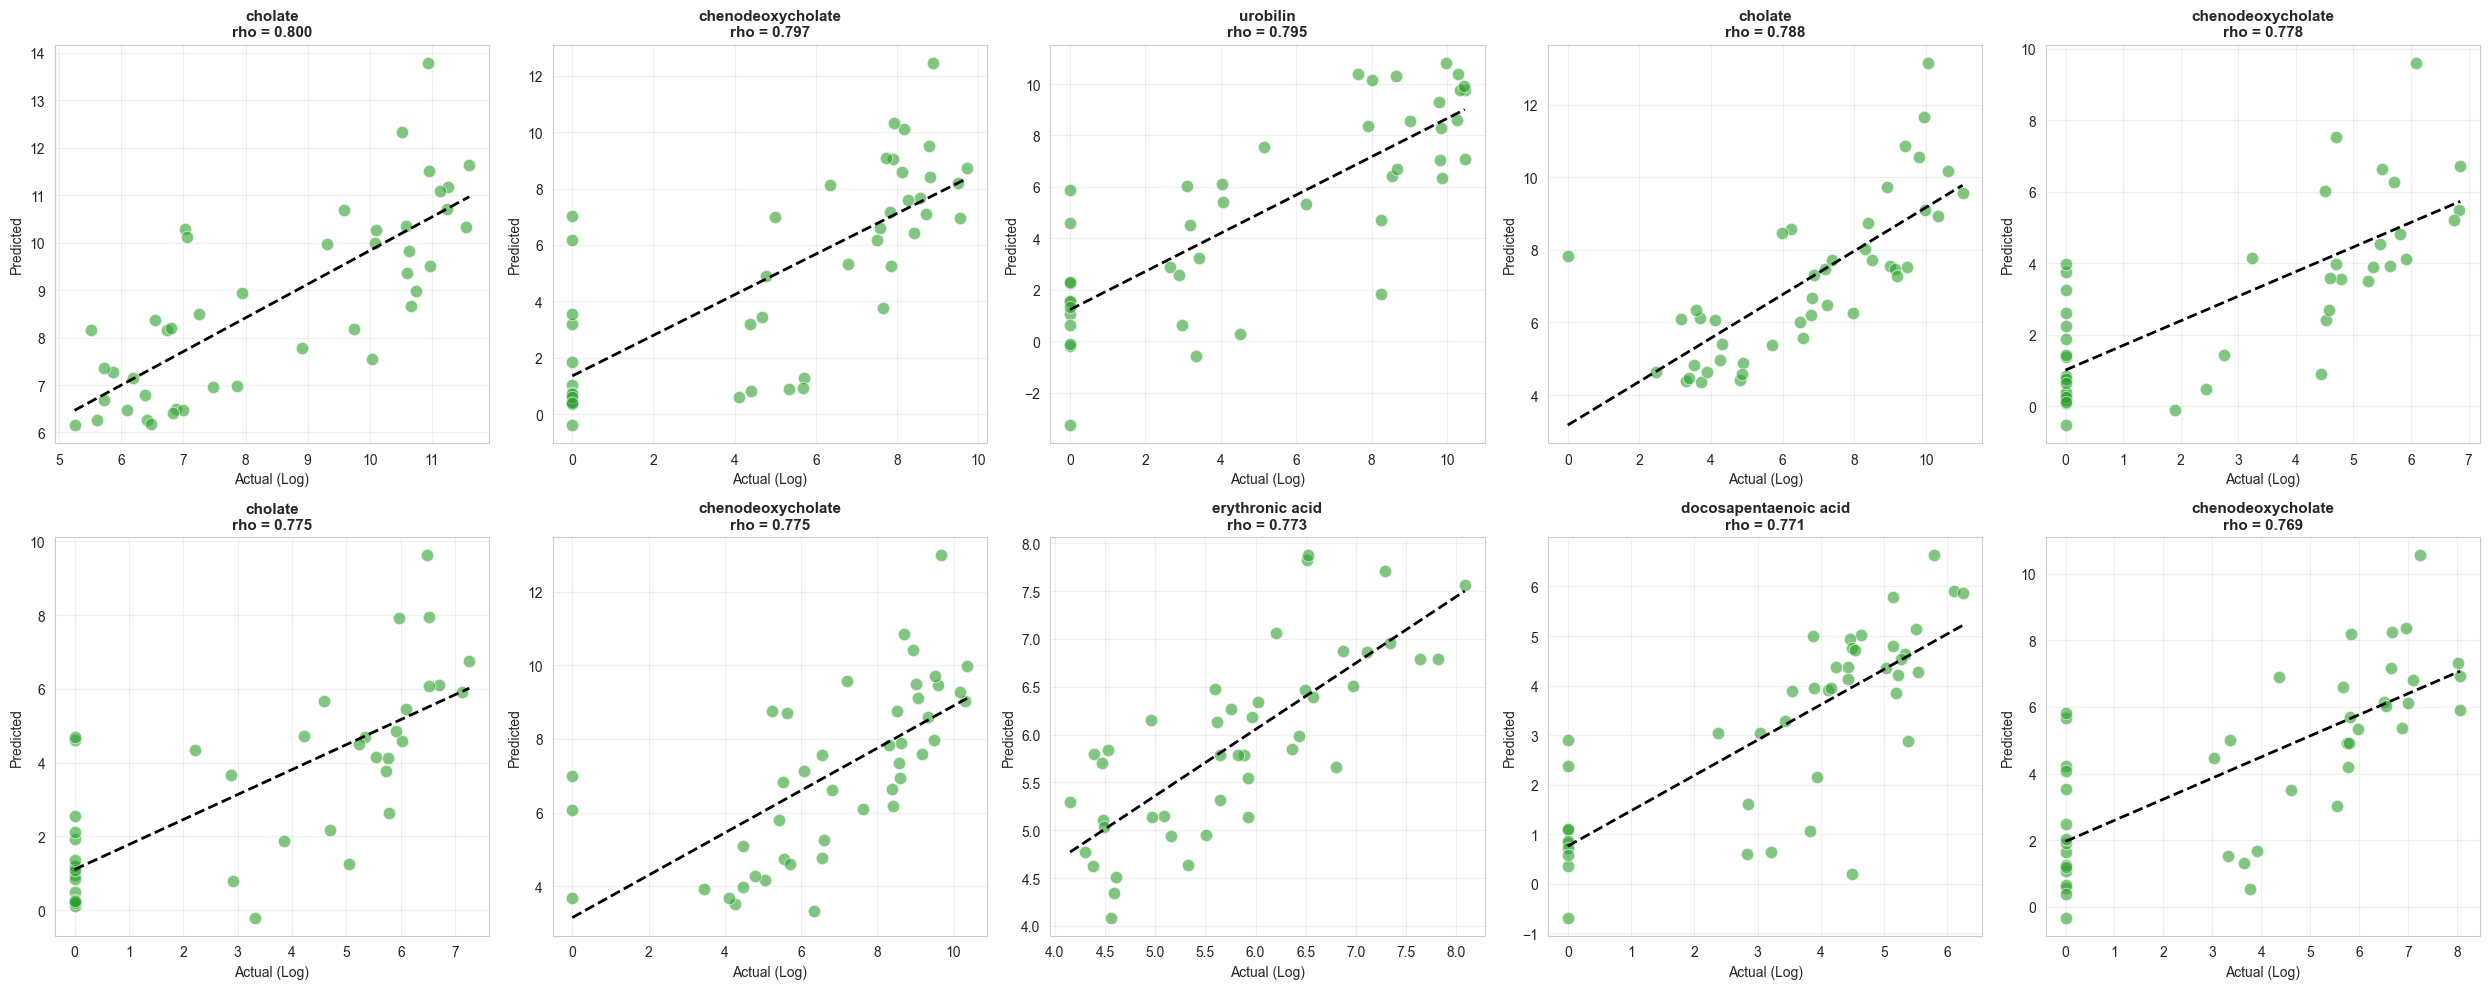

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr, linregress
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import os

warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Choose your dataset
DATASET_PATH = r"E:\Dr_Tang\Code\FRANZOSA_IBD_2019" 

# Best Parameters for BERT
CONFIG = {
    'embed_dim': 384,
    'chunk_size': 750,
    'depth': 2,
    'heads': 12,
    'dropout': 0.5,
    'weight_decay': 0.2,
    'lr': 0.0004,
    'batch_size': 32,
    'epochs': 150,
    'seed': 42,
    'stochastic_depth': 0.1,
    'mixup_alpha': 0.5
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

OUT_DIR = Path("prediction_results_annotated")
OUT_DIR.mkdir(exist_ok=True)

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(dim, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, dim, bias=False)
    def forward(self, x): return self.w3(F.silu(self.w1(x)) * self.w2(x))

class ModernAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim, bias=False)
        self.q_norm = RMSNorm(dim // heads)
        self.k_norm = RMSNorm(dim // heads)
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q, k = self.q_norm(q), self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

class MicrobiomeBERT(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        self.chunk_size = config['chunk_size']
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = config['embed_dim']
        
        self.embed = nn.Sequential(nn.Linear(self.chunk_size, dim, bias=False), RMSNorm(dim), nn.GELU())
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))
        
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=config['heads'], dim_feedforward=dim*4, 
                                           dropout=config['dropout'], activation='gelu', batch_first=True, norm_first=True)
        self.transformer = nn.TransformerEncoder(layer, num_layers=config['depth'])
        self.norm = RMSNorm(dim)
        self.head = nn.Linear(dim, output_dim, bias=False)

    def forward(self, x):
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0: x = torch.cat([x, torch.zeros(B, pad_len, device=x.device)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        x = self.embed(x) + self.pos_embed
        x = self.transformer(x)
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ==========================================
# 3. DATA LOADING
# ==========================================
def load_data():
    path = Path(DATASET_PATH)
    print("Loading data...")
    species = pd.read_csv(path / "species.tsv", sep="\t", index_col=0).astype(float)
    mtb = pd.read_csv(path / "mtb.tsv", sep="\t", index_col=0).astype(float)
    
    # Align
    common = species.index.intersection(mtb.index)
    species = species.loc[common]
    mtb = mtb.loc[common]
    
    # Filter Bacteria
    cols = species.columns
    is_bac = np.array(['d__bacteria' in c.lower() or 'k__bacteria' in c.lower() for c in cols])
    if sum(is_bac) > 0: species = species.loc[:, is_bac]
    
    # Filter Prevalence
    species = species.loc[:, (species > 0).mean() > 0.05]
    species = species.reindex(sorted(species.columns), axis=1)
    
    mtb = mtb.loc[:, (mtb > 0).mean() > 0.05]
    
    # Get names
    metabolite_names = mtb.columns.tolist()
    
    X = np.log1p(species.values)
    y = np.log1p(mtb.values)
    
    return X, y, metabolite_names

X, y, metabolite_names = load_data()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONFIG['seed'])

# Scaling
scaler_x = QuantileTransformer(output_distribution='normal', random_state=CONFIG['seed'])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Use StandardScaler for Y so we can inverse easily
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

X_train_t = torch.FloatTensor(X_train).to(DEVICE)
y_train_t = torch.FloatTensor(y_train).to(DEVICE)
X_test_t = torch.FloatTensor(X_test).to(DEVICE)

# ==========================================
# 4. TRAINING
# ==========================================
print("Training BERT model...")
model = MicrobiomeBERT(X_train.shape[1], y_train.shape[1], CONFIG).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])
criterion = nn.HuberLoss(delta=1.0)
loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=CONFIG['batch_size'], shuffle=True)

for epoch in range(CONFIG['epochs']):
    model.train()
    for xb, yb in loader:
        optimizer.zero_grad()
        lam = np.random.beta(CONFIG['mixup_alpha'], CONFIG['mixup_alpha'])
        idx = torch.randperm(xb.size(0)).to(DEVICE)
        mixed_x = lam * xb + (1 - lam) * xb[idx]
        pred = model(mixed_x)
        loss = lam * criterion(pred, yb) + (1 - lam) * criterion(pred, yb[idx])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    scheduler.step()
    if epoch % 50 == 0: print(f"Epoch {epoch}: Loss {loss.item():.4f}")

# ==========================================
# 5. FILTERING & OUTPUT
# ==========================================
print("Generating predictions...")
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()
    
# Inverse Transform
preds = scaler_y.inverse_transform(preds_scaled)

# Calculate Correlations
all_results = []
for i, name in enumerate(metabolite_names):
    if np.std(preds[:, i]) == 0 or np.std(y_test[:, i]) == 0:
        rho = 0
    else:
        rho, _ = spearmanr(y_test[:, i], preds[:, i])
        
    all_results.append({
        'Metabolite': name,
        'Spearman_Rho': rho,
        'Original_Index': i
    })

df = pd.DataFrame(all_results)

# --- FILTERING LOGIC ---
# We keep only metabolites that DO NOT contain ": NA"
print(f"Total Metabolites: {len(df)}")
df_annotated = df[~df['Metabolite'].str.contains(": NA")]
print(f"Annotated Metabolites (Known Names): {len(df_annotated)}")

# Sort and take Top 10
top_10_annotated = df_annotated.sort_values(by='Spearman_Rho', ascending=False).head(10)

print("\n" + "="*50)
print("TOP 10 ANNOTATED (NAMED) PREDICTIONS")
print("="*50)
print(top_10_annotated[['Metabolite', 'Spearman_Rho']])

# Save to CSV
top_10_annotated.to_csv(OUT_DIR / "top_10_annotated_metabolites.csv", index=False)

# ==========================================
# 6. PLOTTING TOP 10 ANNOTATED
# ==========================================
print("\nGenerating plots for annotated hits...")

fig, axes = plt.subplots(2, 5, figsize=(25, 10)) # 2 rows, 5 cols
axes = axes.flatten()

for i, (_, row) in enumerate(top_10_annotated.iterrows()):
    met_name = row['Metabolite']
    rho = row['Spearman_Rho']
    orig_idx = row['Original_Index']
    
    true_vals = y_test[:, orig_idx]
    pred_vals = preds[:, orig_idx]
    
    ax = axes[i]
    sns.scatterplot(x=true_vals, y=pred_vals, ax=ax, alpha=0.6, color='#2ca02c', s=80, edgecolor='w')
    
    # Regression Line
    slope, intercept, _, _, _ = linregress(true_vals, pred_vals)
    x_range = np.array([min(true_vals), max(true_vals)])
    ax.plot(x_range, slope*x_range + intercept, 'k--', lw=2, label='Trend')
    
    # Clean up long names for title
    display_name = met_name.split(":")[1].strip() if ":" in met_name else met_name
    if len(display_name) > 25: display_name = display_name[:25] + "..."
    
    ax.set_title(f"{display_name}\nrho = {rho:.3f}", fontsize=11, fontweight='bold')
    ax.set_xlabel("Actual (Log)")
    ax.set_ylabel("Predicted")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / "top_10_annotated_scatter.png", dpi=300)
plt.show()

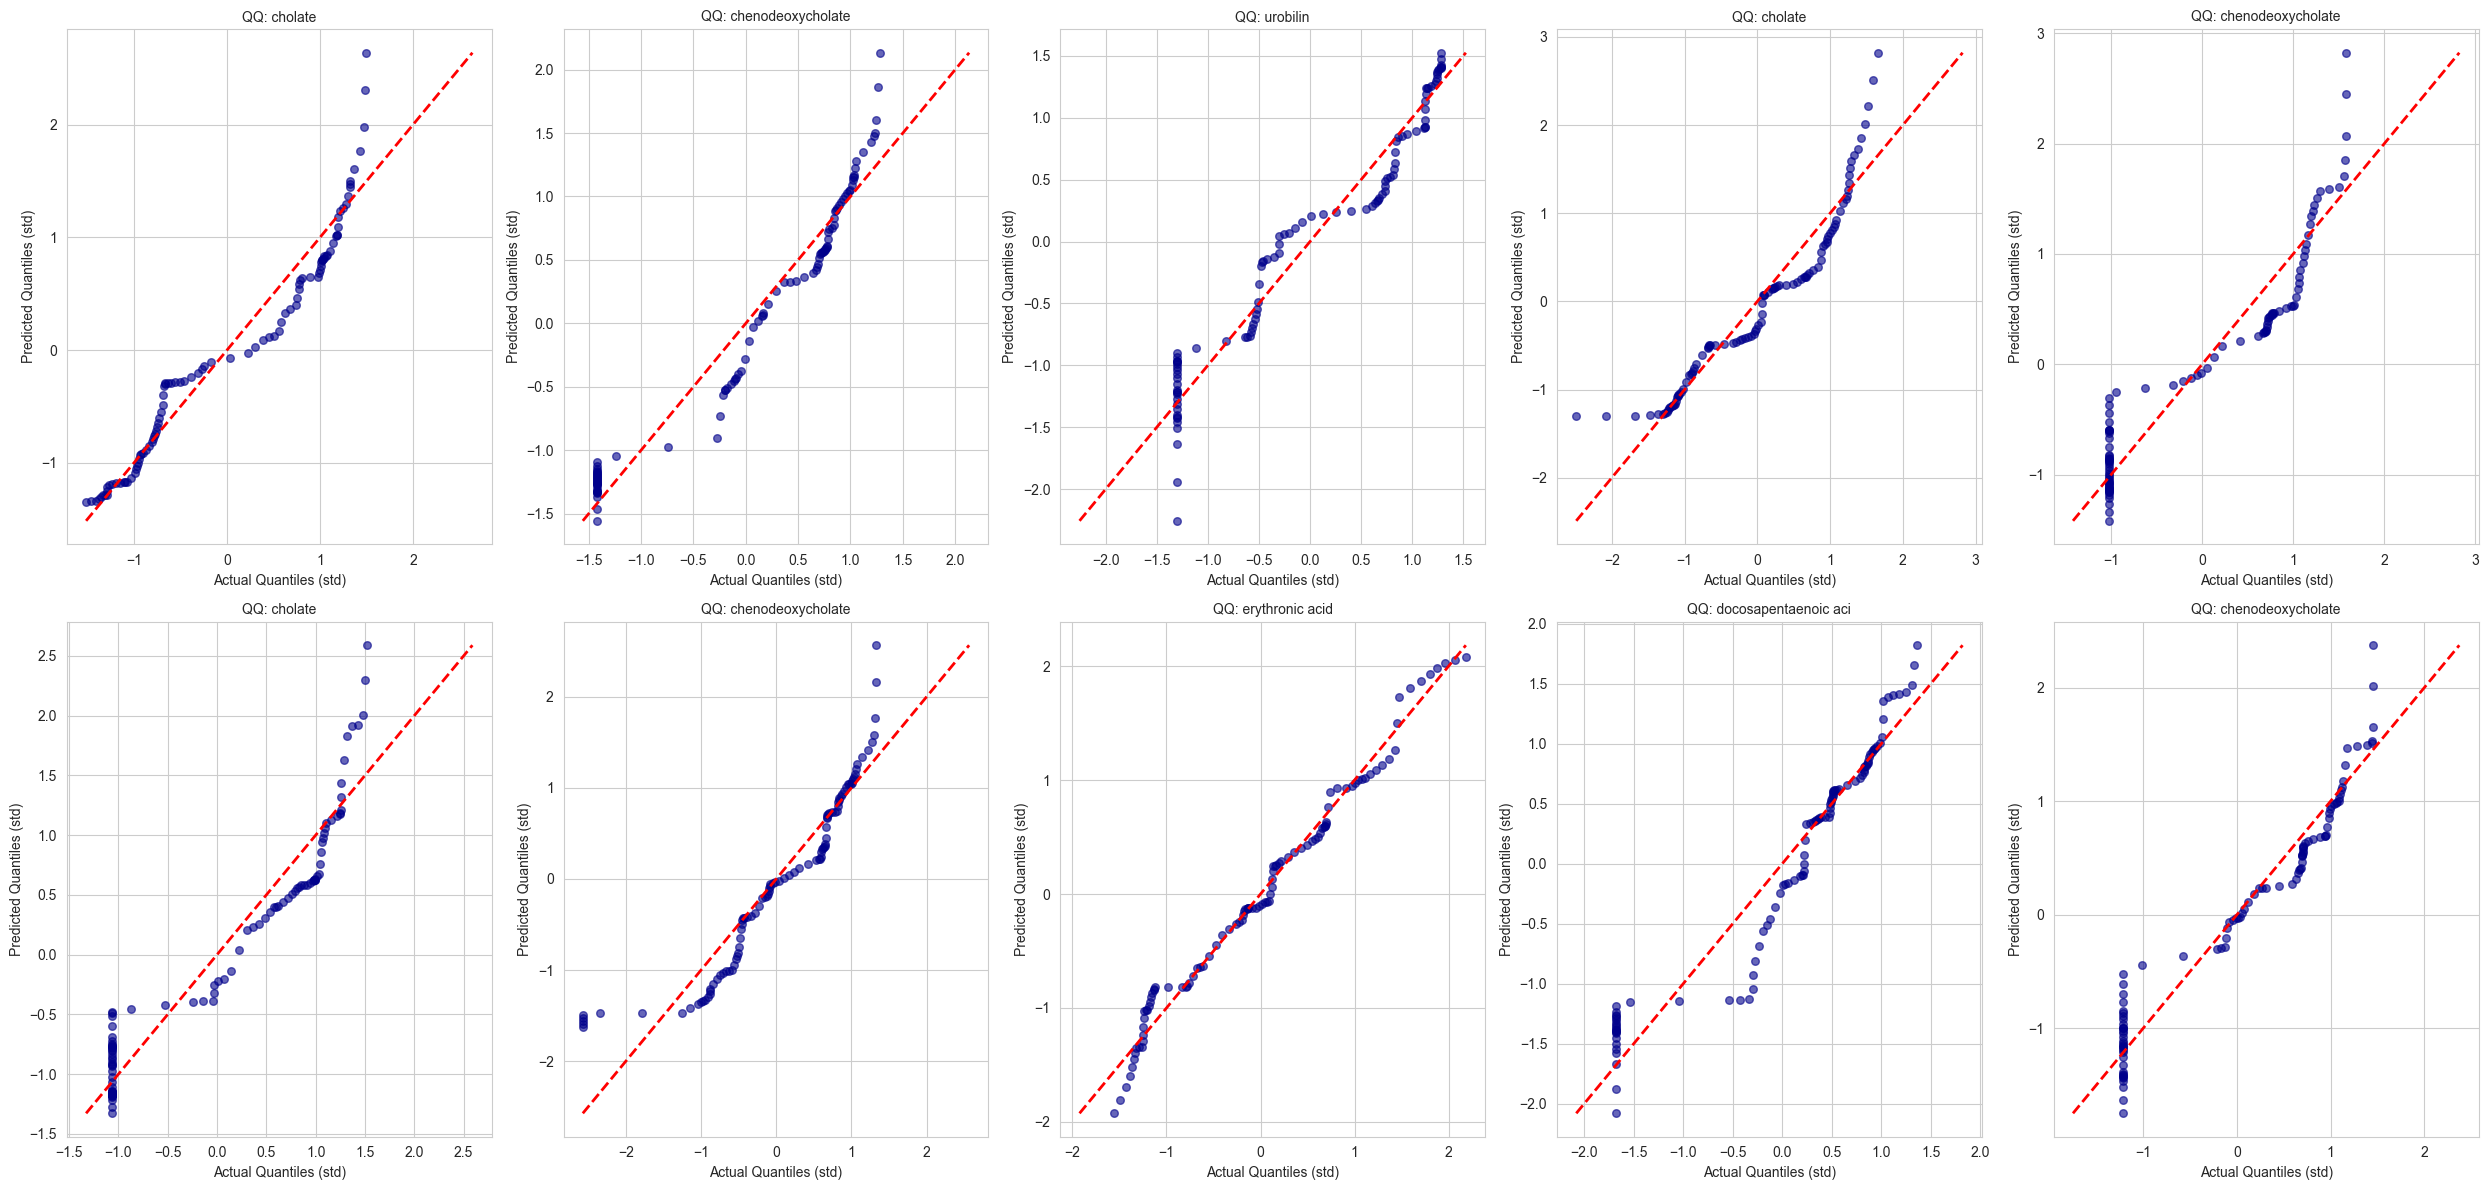

In [39]:
import scipy.stats as stats

def plot_qq_top_hits(y_test, preds, top_10_df):
    fig, axes = plt.subplots(2, 5, figsize=(25, 12))
    axes = axes.flatten()

    for i, (_, row) in enumerate(top_10_df.iterrows()):
        orig_idx = int(row['Original_Index'])
        true_vals = y_test[:, orig_idx]
        pred_vals = preds[:, orig_idx]
        
        # Standardize both to compare distributions (Z-scores)
        true_std = (true_vals - np.mean(true_vals)) / np.std(true_vals)
        pred_std = (pred_vals - np.mean(pred_vals)) / np.std(pred_vals)
        
        ax = axes[i]
        # Calculate quantiles
        percs = np.linspace(0, 100, 100)
        qn_true = np.percentile(true_std, percs)
        qn_pred = np.percentile(pred_std, percs)
        
        ax.scatter(qn_true, qn_pred, color='darkblue', s=30, alpha=0.6)
        
        # Identity line
        low, high = min(qn_true.min(), qn_pred.min()), max(qn_true.max(), qn_pred.max())
        ax.plot([low, high], [low, high], 'r--', lw=2)
        
        display_name = row['Metabolite'].split(":")[1].strip() if ":" in row['Metabolite'] else row['Metabolite']
        ax.set_title(f"QQ: {display_name[:20]}", fontsize=10)
        ax.set_xlabel("Actual Quantiles (std)")
        ax.set_ylabel("Predicted Quantiles (std)")

    plt.tight_layout()
    plt.show()

# Run this after your prediction block
plot_qq_top_hits(y_test, preds, top_10_annotated)

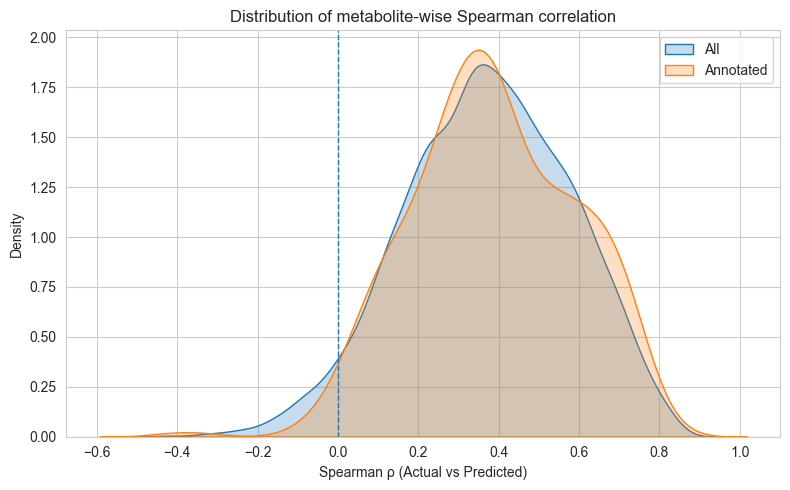

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(data=df_full, x="Spearman_Rho", label="All", fill=True, alpha=0.25)
sns.kdeplot(data=df_full[df_full["Annotated"]], x="Spearman_Rho", label="Annotated", fill=True, alpha=0.25)
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("Spearman ρ (Actual vs Predicted)")
plt.title("Distribution of metabolite-wise Spearman correlation")
plt.legend()
plt.tight_layout()
plt.show()


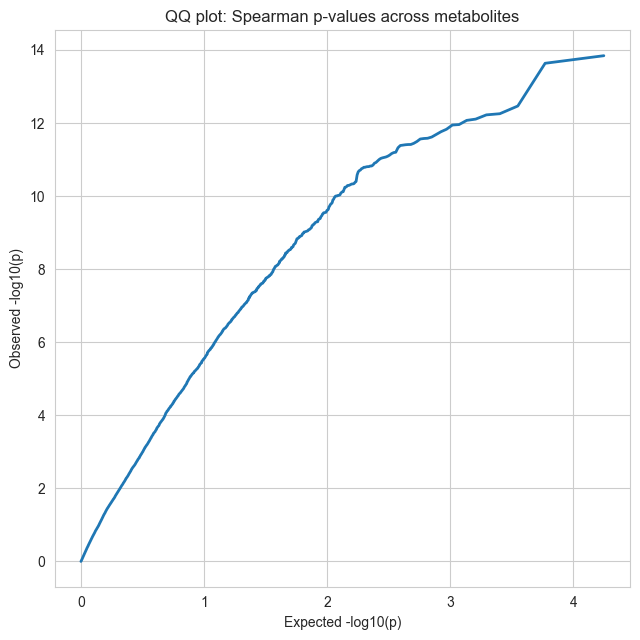

In [41]:
import numpy as np
import matplotlib.pyplot as plt

p = np.clip(df_full["Pvalue"].values, 1e-300, 1.0)
p_sorted = np.sort(p)
n = len(p_sorted)
expected = (np.arange(1, n+1) - 0.5) / n

plt.figure(figsize=(6.5,6.5))
plt.plot(-np.log10(expected), -np.log10(p_sorted), linewidth=2)
mx = max(-np.log10(expected).max(), -np.log10(p_sorted).max())
plt.plot([0, mx], [0, mx], linestyle="--", linewidth=1)
plt.xlabel("Expected -log10(p)")
plt.ylabel("Observed -log10(p)")
plt.title("QQ plot: Spearman p-values across metabolites")
plt.tight_layout()
plt.show()


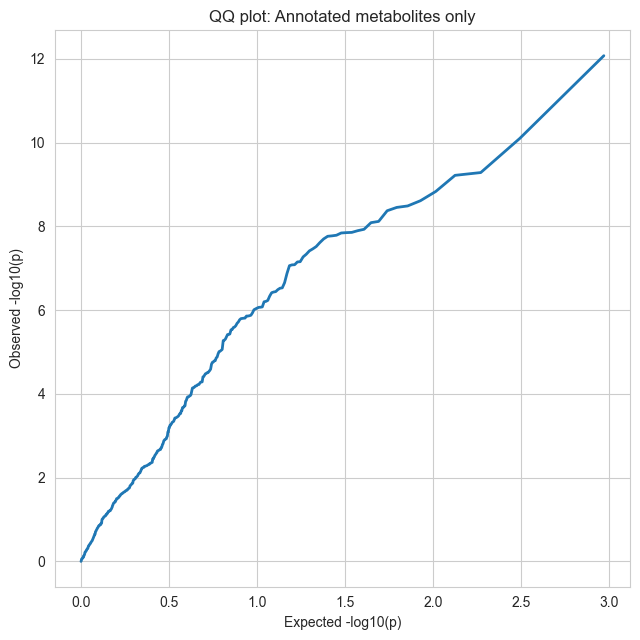

In [42]:
p = np.clip(df_full[df_full["Annotated"]]["Pvalue"].values, 1e-300, 1.0)
p_sorted = np.sort(p)
n = len(p_sorted)
expected = (np.arange(1, n+1) - 0.5) / n

plt.figure(figsize=(6.5,6.5))
plt.plot(-np.log10(expected), -np.log10(p_sorted), linewidth=2)
mx = max(-np.log10(expected).max(), -np.log10(p_sorted).max())
plt.plot([0, mx], [0, mx], linestyle="--", linewidth=1)
plt.xlabel("Expected -log10(p)")
plt.ylabel("Observed -log10(p)")
plt.title("QQ plot: Annotated metabolites only")
plt.tight_layout()
plt.show()


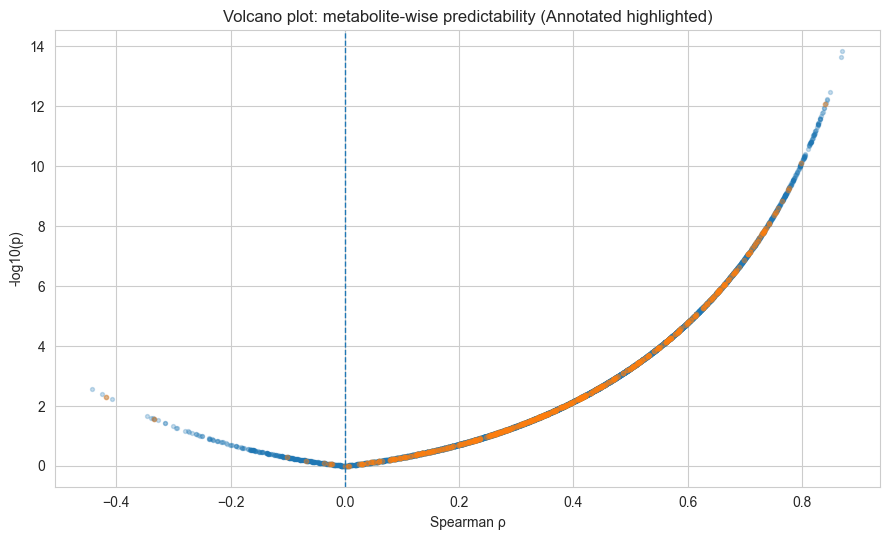

In [43]:
import numpy as np
import matplotlib.pyplot as plt

dfp = df_full.copy()
dfp["neglog10p"] = -np.log10(np.clip(dfp["Pvalue"].values, 1e-300, 1.0))

plt.figure(figsize=(9,5.5))
plt.scatter(dfp["Spearman_Rho"], dfp["neglog10p"], s=8, alpha=0.25)
ann = dfp[dfp["Annotated"]]
plt.scatter(ann["Spearman_Rho"], ann["neglog10p"], s=10, alpha=0.4)

plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("Spearman ρ")
plt.ylabel("-log10(p)")
plt.title("Volcano plot: metabolite-wise predictability (Annotated highlighted)")
plt.tight_layout()
plt.show()


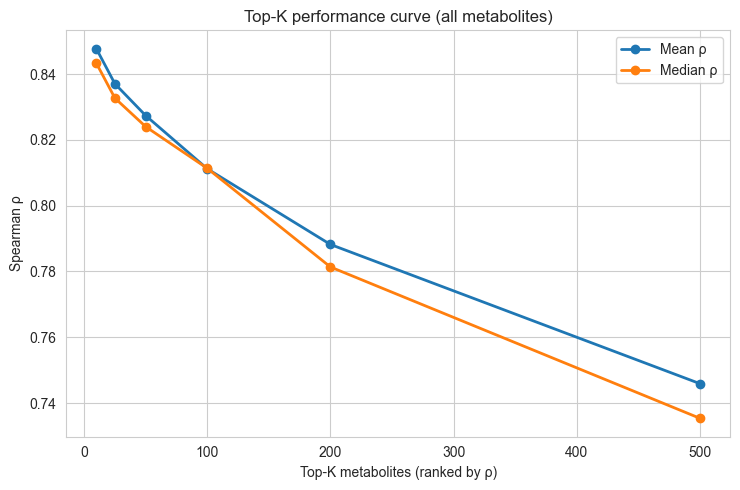

In [44]:
import numpy as np
import matplotlib.pyplot as plt

df_sorted = df_full.sort_values("Spearman_Rho", ascending=False).reset_index(drop=True)

Ks = [10, 25, 50, 100, 200, 500]
means = []
medians = []

for k in Ks:
    vals = df_sorted.loc[:k-1, "Spearman_Rho"].values
    means.append(np.mean(vals))
    medians.append(np.median(vals))

plt.figure(figsize=(7.5,5))
plt.plot(Ks, means, marker="o", linewidth=2, label="Mean ρ")
plt.plot(Ks, medians, marker="o", linewidth=2, label="Median ρ")
plt.xlabel("Top-K metabolites (ranked by ρ)")
plt.ylabel("Spearman ρ")
plt.title("Top-K performance curve (all metabolites)")
plt.legend()
plt.tight_layout()
plt.show()


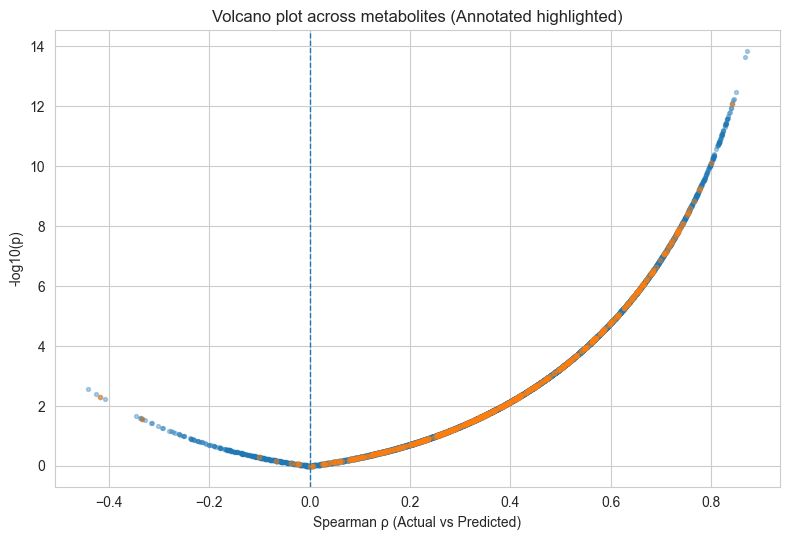

In [45]:
import matplotlib.pyplot as plt
import numpy as np

dfp = df_full.copy()
dfp["neglog10p"] = -np.log10(np.clip(dfp["Pvalue"].values, 1e-300, 1.0))

plt.figure(figsize=(8, 5.5))
plt.scatter(dfp["Spearman_Rho"], dfp["neglog10p"], s=8, alpha=0.35)

# highlight annotated metabolites
ann = dfp[dfp["Annotated"]]
plt.scatter(ann["Spearman_Rho"], ann["neglog10p"], s=10, alpha=0.45)

plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("Spearman ρ (Actual vs Predicted)")
plt.ylabel("-log10(p)")
plt.title("Volcano plot across metabolites (Annotated highlighted)")
plt.tight_layout()
plt.show()


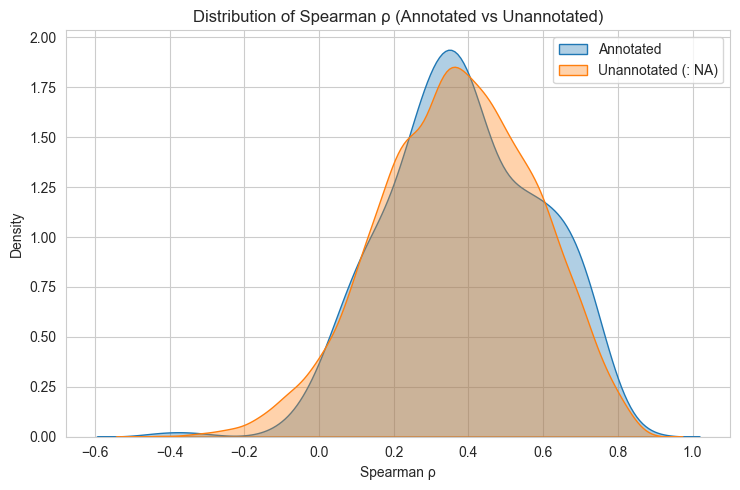

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7.5, 5))
sns.kdeplot(data=df_full[df_full["Annotated"]], x="Spearman_Rho", label="Annotated", fill=True, alpha=0.35)
sns.kdeplot(data=df_full[~df_full["Annotated"]], x="Spearman_Rho", label="Unannotated (: NA)", fill=True, alpha=0.35)
plt.xlabel("Spearman ρ")
plt.title("Distribution of Spearman ρ (Annotated vs Unannotated)")
plt.legend()
plt.tight_layout()
plt.show()


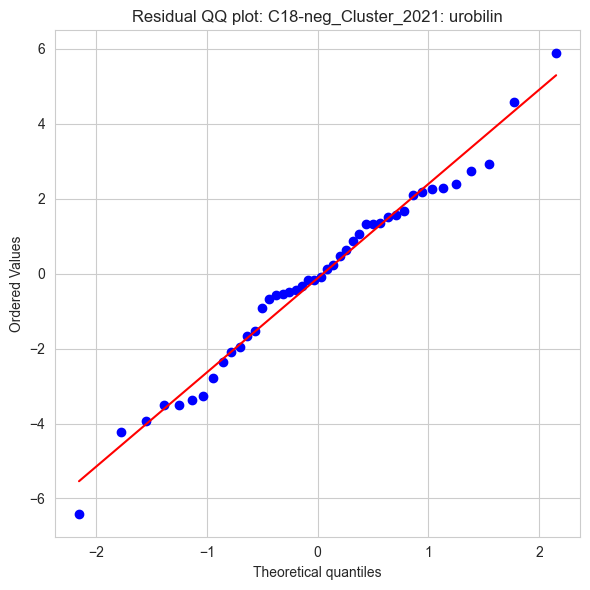

In [47]:
from scipy.stats import probplot
import matplotlib.pyplot as plt
import numpy as np

# choose one metabolite name from your top table
met_name = "C18-neg_Cluster_2021: urobilin"

idx = int(df_full.loc[df_full["Metabolite"] == met_name, "Original_Index"].values[0])
resid = (preds[:, idx] - y_test[:, idx])

plt.figure(figsize=(6, 6))
probplot(resid, dist="norm", plot=plt)
plt.title(f"Residual QQ plot: {met_name}")
plt.tight_layout()
plt.show()


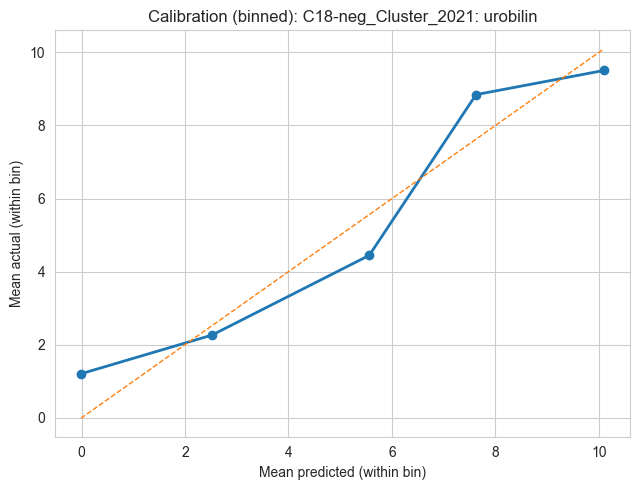

,bin,pred_mean,true_mean,n
0,"(-3.2529999999999997, 1.448]",-0.011909,1.204470,9
1,"(1.448, 4.522]",2.522240,2.264469,9
2,"(4.522, 6.419]",5.561438,4.445887,8
3,"(6.419, 8.88]",7.625051,8.843845,9
4,"(8.88, 10.83]",10.095967,9.505146,9


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

met_name = "C18-neg_Cluster_2021: urobilin"
idx = int(df_full.loc[df_full["Metabolite"] == met_name, "Original_Index"].values[0])

yt = y_test[:, idx]
yp = preds[:, idx]

tmp = pd.DataFrame({"pred": yp, "true": yt})
tmp["bin"] = pd.qcut(tmp["pred"], q=5, duplicates="drop")  # 5 bins

cal = tmp.groupby("bin").agg(pred_mean=("pred","mean"), true_mean=("true","mean"), n=("true","size")).reset_index()

plt.figure(figsize=(6.5, 5))
plt.plot(cal["pred_mean"], cal["true_mean"], marker="o", linewidth=2)
mn = min(cal["pred_mean"].min(), cal["true_mean"].min())
mx = max(cal["pred_mean"].max(), cal["true_mean"].max())
plt.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)

plt.xlabel("Mean predicted (within bin)")
plt.ylabel("Mean actual (within bin)")
plt.title(f"Calibration (binned): {met_name}")
plt.tight_layout()
plt.show()

cal


#  Training MicrobiomeBERT on Synthetic Data

In [23]:
# ============================================================
# MicrobiomeBERT on MiCRM Synthetic Data (end-to-end)
# - Generates synthetic species/metabolite data using MiCRM-like ODE
# - Builds species.tsv + mtb.tsv (optional save)
# - Trains your MicrobiomeBERT (same architecture as your first code)
# - Evaluates mean Spearman on a held-out test set
# ============================================================

import os
import math
import copy
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import spearmanr
from scipy.integrate import solve_ivp

warnings.filterwarnings("ignore")

# ============================================================
# 0) GLOBAL SETTINGS
# ============================================================
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

OUT_DIR = Path("MiCRM_SYNTHETIC_BERT_RUN")
OUT_DIR.mkdir(exist_ok=True)

# ============================================================
# 1) MiCRM SYNTHETIC DATA GENERATION
#    You can adjust Nb, Nr, n_samples
# ============================================================
def make_consumption_matrix(Nb, Nr, connectance=0.5, ensure_each_species_consumes=True):
    """
    C[b, r] in [0,1], sparse with fraction connectance.
    Then apply tradeoff normalization like your code.
    """
    while True:
        C = (np.random.rand(Nb, Nr) < connectance).astype(float) * np.random.uniform(0.0, 1.0, size=(Nb, Nr))
        if (not ensure_each_species_consumes) or (np.sum(C.sum(axis=1) > 0) == Nb):
            break

    # trade-off normalization (your style)
    denom = (C != 0).sum(axis=1).astype(float)
    denom[denom == 0] = 1.0
    C = C / denom[:, None] / connectance * Nr
    return C

def make_production_matrix(Nb, Nr, connectance=0.5, C=None):
    """
    P[b, r] sparse, normalized per species.
    Enforce no overlap with consumption links if C provided.
    """
    P = (np.random.rand(Nb, Nr) < connectance).astype(float) * np.random.uniform(0.0, 1.0, size=(Nb, Nr))
    if C is not None:
        P[C > 0] = 0.0

    denom = P.sum(axis=1)
    denom[denom <= 0] = 1.0
    P = P / denom[:, None]
    return P

def CRM_microbial_community(
    i_absence_microbes,
    i_absence_nutrients,
    R_supply,
    consumption_mat,
    depletion_mat,
    production_mat,
    leakage_fraction=0.5,
    delta=0.2,
    t_end=1e5,
    n_eval=256,
):
    """
    State y = [R (Nr), B (Nb)].
    Returns final (R_end, B_end).
    """

    C = consumption_mat.copy()
    P = production_mat.copy()
    Dmat = depletion_mat.copy()

    # Remove absent microbes / nutrients by zeroing relevant links
    # microbes absent: set their consumption/production to 0, and resource depletion contributions to 0
    if len(i_absence_microbes) > 0:
        C[i_absence_microbes, :] = 0.0
        P[i_absence_microbes, :] = 0.0
        Dmat[:, i_absence_microbes] = 0.0

    Nb, Nr = C.shape[0], C.shape[1]

    # initial conditions
    B0 = np.ones(Nb, dtype=float)
    R0 = np.ones(Nr, dtype=float)
    if len(i_absence_microbes) > 0:
        B0[i_absence_microbes] = 0.0
    if len(i_absence_nutrients) > 0:
        R0[i_absence_nutrients] = 0.0

    y0 = np.concatenate([R0, B0], axis=0)

    # log-spaced eval times helps with stiff dynamics
    t_eval = np.unique(np.clip(np.logspace(-1, np.log10(t_end), n_eval), 1e-1, t_end))

    def dydt(t, y):
        R = y[:Nr]
        B = y[Nr:]

        # ensure non-negative in computation
        R = np.clip(R, 0.0, None)
        B = np.clip(B, 0.0, None)

        # J_in[b, r] = C[b,r] * R[r]
        J_in = C * R[None, :]
        # leakage -> byproducts; your simplification:
        # J_out[b, r] = sum_r' J_in[b,r'] * P[b,r] * leakage
        J_out = (np.sum(J_in, axis=1)[:, None]) * P * leakage_fraction

        # dB/dt = B * (sum_r C[b,r]*R[r])*(1-leak) - delta*B
        growth_term = (C @ R) * (1.0 - leakage_fraction)
        dB = B * growth_term - delta * B

        # dR/dt = R_supply - R * (depletion_mat @ B) + (J_out^T @ B) - delta*R
        # depletion_mat is (Nr, Nb) so depletion_mat @ B is (Nr,)
        depletion = R * (Dmat @ B)
        byprod = (J_out.T @ B)
        dR = R_supply - depletion + byprod - delta * R

        return np.concatenate([dR, dB], axis=0)

    sol = solve_ivp(
        dydt,
        t_span=(float(t_eval[0]), float(t_eval[-1])),
        y0=y0,
        method="LSODA",
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-4,
    )

    y_end = sol.y[:, -1]
    R_end = np.clip(y_end[:Nr], 0.0, None)
    B_end = np.clip(y_end[Nr:], 0.0, None)

    # tiny thresholding
    R_end[R_end < 1e-8] = 0.0
    B_end[B_end < 1e-8] = 0.0

    return R_end, B_end

def generate_micrm_dataset(
    n_samples=500,
    Nb=100,
    Nr=100,
    frac_species_present=0.5,
    frac_nutrients_present=0.5,
    C_connectance=0.5,
    P_connectance=0.5,
    leakage_fraction=0.5,
    delta=0.2,
    t_end=1e5,
):
    """
    Returns:
      species_df: (n_samples, Nb) relative abundances
      mtb_df:     (n_samples, Nr) concentrations
    """
    # define global interaction matrices once
    C = make_consumption_matrix(Nb, Nr, connectance=C_connectance, ensure_each_species_consumes=True)
    depletion_mat = C.T.copy()
    P = make_production_matrix(Nb, Nr, connectance=P_connectance, C=C)

    # resource supply baseline
    R_supply_base = np.random.uniform(0.0, 1.0, size=Nr)

    species_all = np.zeros((n_samples, Nb), dtype=float)
    mtb_all = np.zeros((n_samples, Nr), dtype=float)

    for i in range(n_samples):
        if i % max(1, (n_samples // 10)) == 0:
            print(f"Synthetic sample {i}/{n_samples}")

        # presence masks
        nutrients_present = (np.random.rand(Nr) < frac_nutrients_present)
        microbes_present = (np.random.rand(Nb) < frac_species_present)

        i_abs_nutrients = np.where(~nutrients_present)[0]
        i_abs_microbes = np.where(~microbes_present)[0]

        R_supply = R_supply_base.copy()
        R_supply[i_abs_nutrients] = 0.0

        R_end, B_end = CRM_microbial_community(
            i_absence_microbes=i_abs_microbes,
            i_absence_nutrients=i_abs_nutrients,
            R_supply=R_supply,
            consumption_mat=C,
            depletion_mat=depletion_mat,
            production_mat=P,
            leakage_fraction=leakage_fraction,
            delta=delta,
            t_end=t_end,
            n_eval=256,
        )

        # species relative abundance (input)
        if B_end.sum() > 0:
            rel = B_end / (B_end.sum() + 1e-12)
        else:
            rel = B_end

        species_all[i, :] = rel
        mtb_all[i, :] = R_end

    # Build dataframes (sample IDs)
    sample_ids = [f"S{i:04d}" for i in range(n_samples)]
    species_cols = [f"sp_{j:03d}" for j in range(Nb)]
    mtb_cols = [f"mtb_{k:03d}" for k in range(Nr)]

    species_df = pd.DataFrame(species_all, index=sample_ids, columns=species_cols)
    mtb_df = pd.DataFrame(mtb_all, index=sample_ids, columns=mtb_cols)

    return species_df, mtb_df

# --- Generate synthetic dataset ---
species_df, mtb_df = generate_micrm_dataset(
    n_samples=500,   # change if needed
    Nb=100,
    Nr=100,
    frac_species_present=0.5,
    frac_nutrients_present=0.5,
    C_connectance=0.5,
    P_connectance=0.5,
    leakage_fraction=0.5,
    delta=0.2,
    t_end=1e5,
)

print("Synthetic species shape:", species_df.shape)
print("Synthetic mtb shape:", mtb_df.shape)

# Optional: save like your real datasets
species_df.to_csv(OUT_DIR / "species.tsv", sep="\t")
mtb_df.to_csv(OUT_DIR / "mtb.tsv", sep="\t")
print("Saved:", OUT_DIR / "species.tsv", "and", OUT_DIR / "mtb.tsv")

# ============================================================
# 2) MicrobiomeBERT (YOUR FIRST ARCHITECTURE)
# ============================================================
BEST_PARAMS = {
    'depth': 2,
    'embed_dim': 384,
    'heads': 12,
    'dropout': 0.5,
    'weight_decay': 0.2,
    'batch_size': 32,
    'lr': 0.0004,
    'chunk_size': 50,          # IMPORTANT: for Nb=100, smaller chunk is better than 750
    'stochastic_depth': 0.1,
    'mixup_alpha': 0.5,
    'epochs': 100
}

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps) * self.weight

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim, bias=False):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w2 = nn.Linear(dim, hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class ModernAttention(nn.Module):
    def __init__(self, dim, heads, qk_norm=True, bias=False):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj = nn.Linear(dim, dim, bias=bias)
        if qk_norm:
            self.q_norm = RMSNorm(dim // heads)
            self.k_norm = RMSNorm(dim // heads)
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q, k = self.q_norm(q), self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    return x.div(keep_prob) * random_tensor

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class BERTBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4, drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        self.attn = ModernAttention(dim, heads, qk_norm=True, bias=False)
        self.ffn = SwiGLU(dim, dim * mlp_ratio, bias=False)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x

class MicrobiomeBERT(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()
        self.chunk_size = config['chunk_size']
        self.num_tokens = math.ceil(input_dim / self.chunk_size)
        dim = config['embed_dim']

        self.embed = nn.Sequential(
            nn.Linear(self.chunk_size, dim, bias=False),
            RMSNorm(dim),
            nn.GELU()
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, dim))
        dpr = [x.item() for x in torch.linspace(0, config['stochastic_depth'], config['depth'])]
        self.blocks = nn.ModuleList([
            BERTBlock(dim, config['heads'], drop=config['dropout'], drop_path=dpr[i])
            for i in range(config['depth'])
        ])
        self.norm = RMSNorm(dim)
        self.head = nn.Sequential(
            nn.Linear(dim, dim, bias=False),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim, output_dim, bias=False)
        )

    def forward(self, x):
        B, N_feat = x.shape
        pad_len = (self.num_tokens * self.chunk_size) - N_feat
        if pad_len > 0:
            x = torch.cat([x, torch.zeros(B, pad_len, device=x.device)], dim=1)
        x = x.view(B, self.num_tokens, self.chunk_size)
        x = self.embed(x) + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.norm(x.mean(dim=1))
        return self.head(x)

# ============================================================
# 3) TRAINING UTILS
# ============================================================
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    idx = torch.randperm(x.size(0), device=x.device)
    return lam * x + (1 - lam) * x[idx], y, y[idx], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def mean_spearman(preds, y_true):
    corrs = []
    for j in range(y_true.shape[1]):
        if np.std(preds[:, j]) == 0 or np.std(y_true[:, j]) == 0:
            r = 0.0
        else:
            r, _ = spearmanr(preds[:, j], y_true[:, j])
            if np.isnan(r):
                r = 0.0
        corrs.append(r)
    return float(np.nanmean(corrs))

# ============================================================
# 4) PREPARE DATA LIKE YOUR PIPELINE
# ============================================================
X_full = np.log1p(species_df.values.astype(float))      # (n, Nb)
y_full = np.log1p(mtb_df.values.astype(float))          # (n, Nr)

X_train_all, X_test, y_train_all, y_test_raw = train_test_split(
    X_full, y_full, test_size=0.2, random_state=SEED
)

# Use a validation split (avoid test leakage)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2, random_state=SEED
)

# Fit scalers on train only
scaler_x = QuantileTransformer(output_distribution="normal", random_state=SEED)
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)   # only for monitoring in scaled space if needed

# Tensors
X_train_t = torch.FloatTensor(X_train).to(DEVICE)
y_train_t = torch.FloatTensor(y_train_scaled).to(DEVICE)
X_val_t = torch.FloatTensor(X_val).to(DEVICE)
X_test_t = torch.FloatTensor(X_test).to(DEVICE)

# ============================================================
# 5) TRAIN MicrobiomeBERT
# ============================================================
model = MicrobiomeBERT(input_dim=X_train.shape[1], output_dim=y_train.shape[1], config=BEST_PARAMS).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=BEST_PARAMS["lr"], weight_decay=BEST_PARAMS["weight_decay"])
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=BEST_PARAMS["lr"],
    epochs=BEST_PARAMS["epochs"],
    steps_per_epoch=(len(X_train) // BEST_PARAMS["batch_size"] + 1),
    pct_start=0.3,
)
criterion = nn.HuberLoss(delta=1.0)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=BEST_PARAMS["batch_size"],
    shuffle=True
)

best_val = -1e9
best_state = None
patience = 20
pat_cnt = 0

for epoch in range(BEST_PARAMS["epochs"]):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        mx, y_a, y_b, lam = mixup_data(xb, yb, BEST_PARAMS["mixup_alpha"])
        pred = model(mx)
        loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Validation (compute mean spearman on VAL in original space)
    model.eval()
    with torch.no_grad():
        pred_val_scaled = model(X_val_t).cpu().numpy()
        pred_val = scaler_y.inverse_transform(pred_val_scaled)
        val_rho = mean_spearman(pred_val, y_val)

    if (epoch % 10) == 0:
        print(f"Epoch {epoch:03d} | val mean Spearman: {val_rho:.4f}")

    if val_rho > best_val:
        best_val = val_rho
        best_state = copy.deepcopy(model.state_dict())
        pat_cnt = 0
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("Early stopping.")
            break

# load best
if best_state is not None:
    model.load_state_dict(best_state)

# ============================================================
# 6) TEST EVALUATION
# ============================================================
model.eval()
with torch.no_grad():
    pred_test_scaled = model(X_test_t).cpu().numpy()

pred_test = scaler_y.inverse_transform(pred_test_scaled)
test_rho = mean_spearman(pred_test, y_test_raw)
print("\nFINAL TEST mean Spearman:", round(test_rho, 4))

# Save a simple summary
pd.DataFrame({"metric": ["mean_spearman"], "value": [test_rho]}).to_csv(OUT_DIR / "test_summary.csv", index=False)
print("Saved summary to:", OUT_DIR / "test_summary.csv")


Using device: cuda
Synthetic sample 0/500
Synthetic sample 50/500
Synthetic sample 100/500
Synthetic sample 150/500
Synthetic sample 200/500
Synthetic sample 250/500
Synthetic sample 300/500
Synthetic sample 350/500
Synthetic sample 400/500
Synthetic sample 450/500
Synthetic species shape: (500, 100)
Synthetic mtb shape: (500, 100)
Saved: MiCRM_SYNTHETIC_BERT_RUN\species.tsv and MiCRM_SYNTHETIC_BERT_RUN\mtb.tsv
Epoch 000 | val mean Spearman: 0.0180
Epoch 010 | val mean Spearman: 0.1660
Epoch 020 | val mean Spearman: 0.2713
Epoch 030 | val mean Spearman: 0.2845
Epoch 040 | val mean Spearman: 0.2909
Epoch 050 | val mean Spearman: 0.2908
Epoch 060 | val mean Spearman: 0.2963
Epoch 070 | val mean Spearman: 0.2961
Epoch 080 | val mean Spearman: 0.2962
Early stopping.

FINAL TEST mean Spearman: 0.3038
Saved summary to: MiCRM_SYNTHETIC_BERT_RUN\test_summary.csv


In [24]:
import numpy as np
import pandas as pd

# If you didn't keep them in memory, you can reload the saved synthetic TSVs:
# species_df = pd.read_csv(OUT_DIR / "species.tsv", sep="\t", index_col=0)
# mtb_df     = pd.read_csv(OUT_DIR / "mtb.tsv", sep="\t", index_col=0)

# pred_test: (n_test, Nr)
# y_test_raw: (n_test, Nr)
print(pred_test.shape, y_test_raw.shape)


(100, 100) (100, 100)


Frac 0.1 -> Test mean Spearman 0.1399
Frac 0.2 -> Test mean Spearman 0.1748
Frac 0.4 -> Test mean Spearman 0.2364
Frac 0.6 -> Test mean Spearman 0.2569
Frac 0.8 -> Test mean Spearman 0.2866
Frac 1.0 -> Test mean Spearman 0.2985


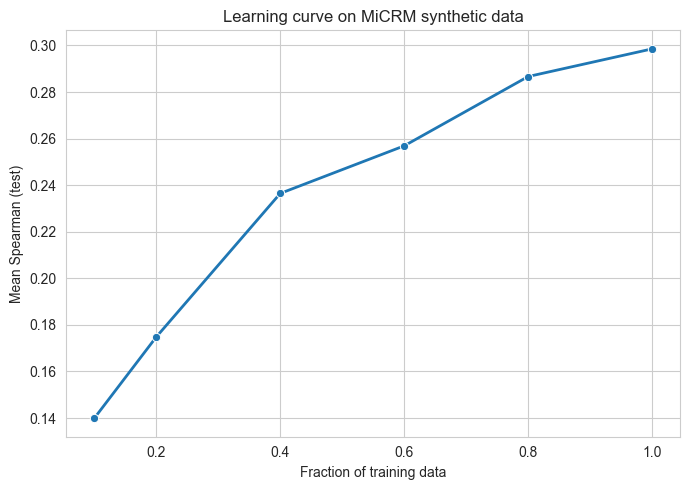

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from scipy.stats import spearmanr

def mean_spearman(preds, y_true):
    corrs = []
    for j in range(y_true.shape[1]):
        if np.std(preds[:, j]) == 0 or np.std(y_true[:, j]) == 0:
            r = 0.0
        else:
            r, _ = spearmanr(preds[:, j], y_true[:, j])
            if np.isnan(r): r = 0.0
        corrs.append(r)
    return float(np.nanmean(corrs))

TRAIN_FRACS = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
SEED = 42

# Build X,y from the synthetic TSVs you just generated
X_full = np.log1p(species_df.values.astype(float))
y_full = np.log1p(mtb_df.values.astype(float))

# fixed test set
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=SEED
)

curve = []
for frac in TRAIN_FRACS:
    n = int(len(X_train_all) * frac)
    if n < 32:
        continue

    rng = np.random.RandomState(SEED)
    idx = rng.permutation(len(X_train_all))[:n]
    X_tr = X_train_all[idx]
    y_tr = y_train_all[idx]

    # val split
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=SEED)

    # scale
    sx = QuantileTransformer(output_distribution="normal", random_state=SEED)
    X_tr_s = sx.fit_transform(X_tr)
    X_val_s = sx.transform(X_val)
    X_te_s  = sx.transform(X_test)

    sy = StandardScaler()
    y_tr_s = sy.fit_transform(y_tr)

    # tensors
    X_tr_t = torch.FloatTensor(X_tr_s).to(DEVICE)
    y_tr_t = torch.FloatTensor(y_tr_s).to(DEVICE)
    X_te_t = torch.FloatTensor(X_te_s).to(DEVICE)

    # train a fresh model quickly (reuse your BEST_PARAMS & MicrobiomeBERT)
    model_lc = MicrobiomeBERT(X_tr_s.shape[1], y_tr.shape[1], BEST_PARAMS).to(DEVICE)
    opt = optim.AdamW(model_lc.parameters(), lr=BEST_PARAMS["lr"], weight_decay=BEST_PARAMS["weight_decay"])
    sch = optim.lr_scheduler.OneCycleLR(
        opt, max_lr=BEST_PARAMS["lr"], epochs=60,
        steps_per_epoch=(len(X_tr_s)//BEST_PARAMS["batch_size"] + 1)
    )
    crit = nn.HuberLoss(delta=1.0)
    loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=BEST_PARAMS["batch_size"], shuffle=True)

    best = -1e9
    best_state = None
    patience, pc = 12, 0

    for ep in range(60):
        model_lc.train()
        for xb, yb in loader:
            opt.zero_grad()
            pred = model_lc(xb)
            loss = crit(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_lc.parameters(), 1.0)
            opt.step()
            sch.step()

        # early stop using test mean spearman (fast proxy)
        model_lc.eval()
        with torch.no_grad():
            p_s = model_lc(X_te_t).cpu().numpy()
            p = sy.inverse_transform(p_s)
            rho = mean_spearman(p, y_test)

        if rho > best:
            best = rho
            best_state = copy.deepcopy(model_lc.state_dict())
            pc = 0
        else:
            pc += 1
            if pc >= patience:
                break

    curve.append({"Fraction": frac, "Samples": n, "Test_Spearman": best})
    print(f"Frac {frac} -> Test mean Spearman {best:.4f}")

df_curve = pd.DataFrame(curve)

plt.figure(figsize=(7,5))
sns.lineplot(data=df_curve, x="Fraction", y="Test_Spearman", marker="o", linewidth=2)
plt.xlabel("Fraction of training data")
plt.ylabel("Mean Spearman (test)")
plt.title("Learning curve on MiCRM synthetic data")
plt.tight_layout()
plt.show()

df_curve.to_csv(OUT_DIR / "synthetic_learning_curve.csv", index=False)


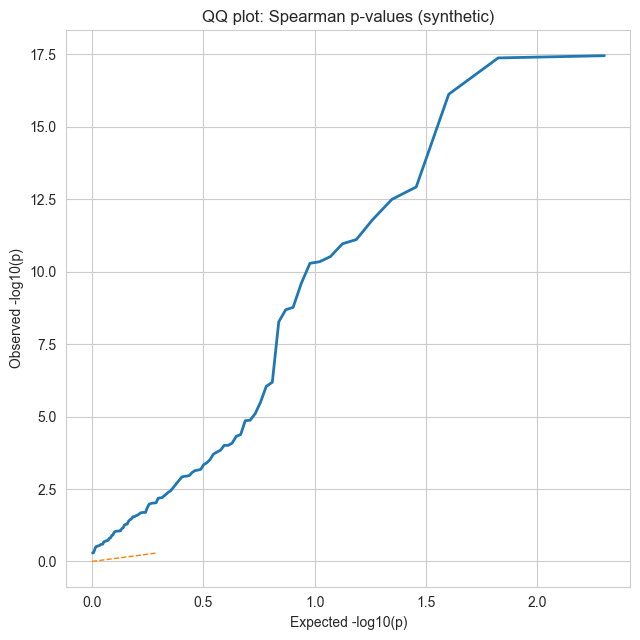

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

pvals = []
rhos = []

for j in range(y_test_raw.shape[1]):
    yt = y_test_raw[:, j]
    yp = pred_test[:, j]
    if np.std(yt) == 0 or np.std(yp) == 0:
        r, p = 0.0, 1.0
    else:
        r, p = spearmanr(yt, yp)
        if np.isnan(r) or np.isnan(p):
            r, p = 0.0, 1.0
    rhos.append(r)
    pvals.append(p)

pvals = np.clip(np.array(pvals), 1e-300, 1.0)
p_sorted = np.sort(pvals)
n = len(p_sorted)
expected = (np.arange(1, n+1) - 0.5) / n

plt.figure(figsize=(6.5,6.5))
plt.plot(-np.log10(expected), -np.log10(p_sorted), linewidth=2)
mx = max(-np.log10(expected).max(), -np.log10(p_sorted).max())
plt.plot([0, mx], [0, mx], linestyle="--", linewidth=1)
plt.xlabel("Expected -log10(p)")
plt.ylabel("Observed -log10(p)")
plt.title("QQ plot: Spearman p-values (synthetic)")
plt.tight_layout()
plt.show()


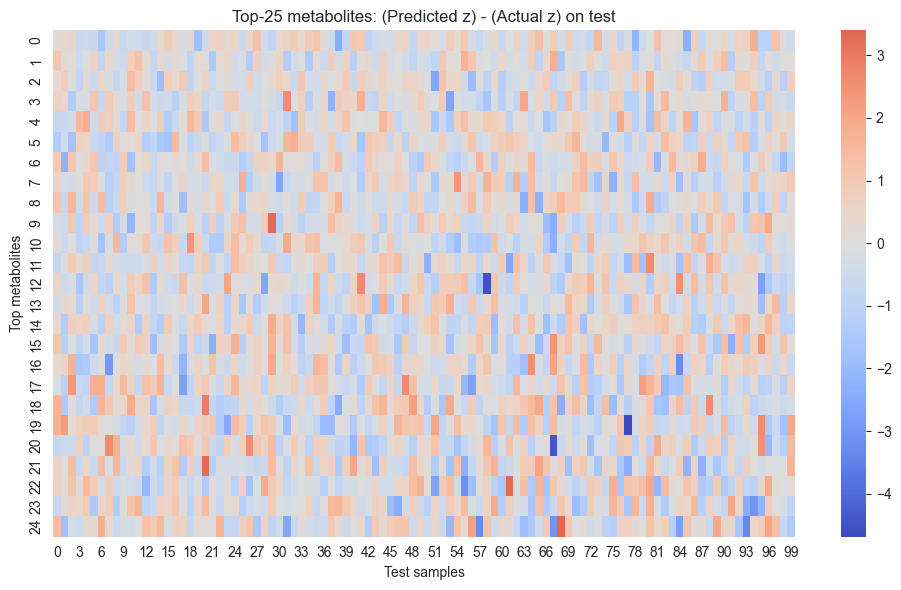

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

met_names = mtb_df.columns.tolist()

rows = []
for j, name in enumerate(met_names):
    yt = y_test_raw[:, j]
    yp = pred_test[:, j]
    if np.std(yt) == 0 or np.std(yp) == 0:
        rho = 0.0
    else:
        rho, _ = spearmanr(yt, yp)
        if np.isnan(rho): rho = 0.0
    rows.append((name, rho))

df_rho = pd.DataFrame(rows, columns=["Metabolite", "Spearman_Rho"]).sort_values("Spearman_Rho", ascending=False)

topk = 25
top = df_rho.head(topk)["Metabolite"].tolist()

# build a small matrix: (topk metabolites) x (test samples) with residuals or values
# here: show Spearman ranks match visually using sorted-by-true order
mat = []
for name in top:
    j = met_names.index(name)
    yt = y_test_raw[:, j]
    yp = pred_test[:, j]
    # normalize each row for visualization
    yt_n = (yt - yt.mean()) / (yt.std() + 1e-9)
    yp_n = (yp - yp.mean()) / (yp.std() + 1e-9)
    mat.append(yp_n - yt_n)  # residual pattern

mat = np.array(mat)

plt.figure(figsize=(10,6))
sns.heatmap(mat, cmap="coolwarm", center=0)
plt.xlabel("Test samples")
plt.ylabel("Top metabolites")
plt.title("Top-25 metabolites: (Predicted z) - (Actual z) on test")
plt.tight_layout()
plt.show()


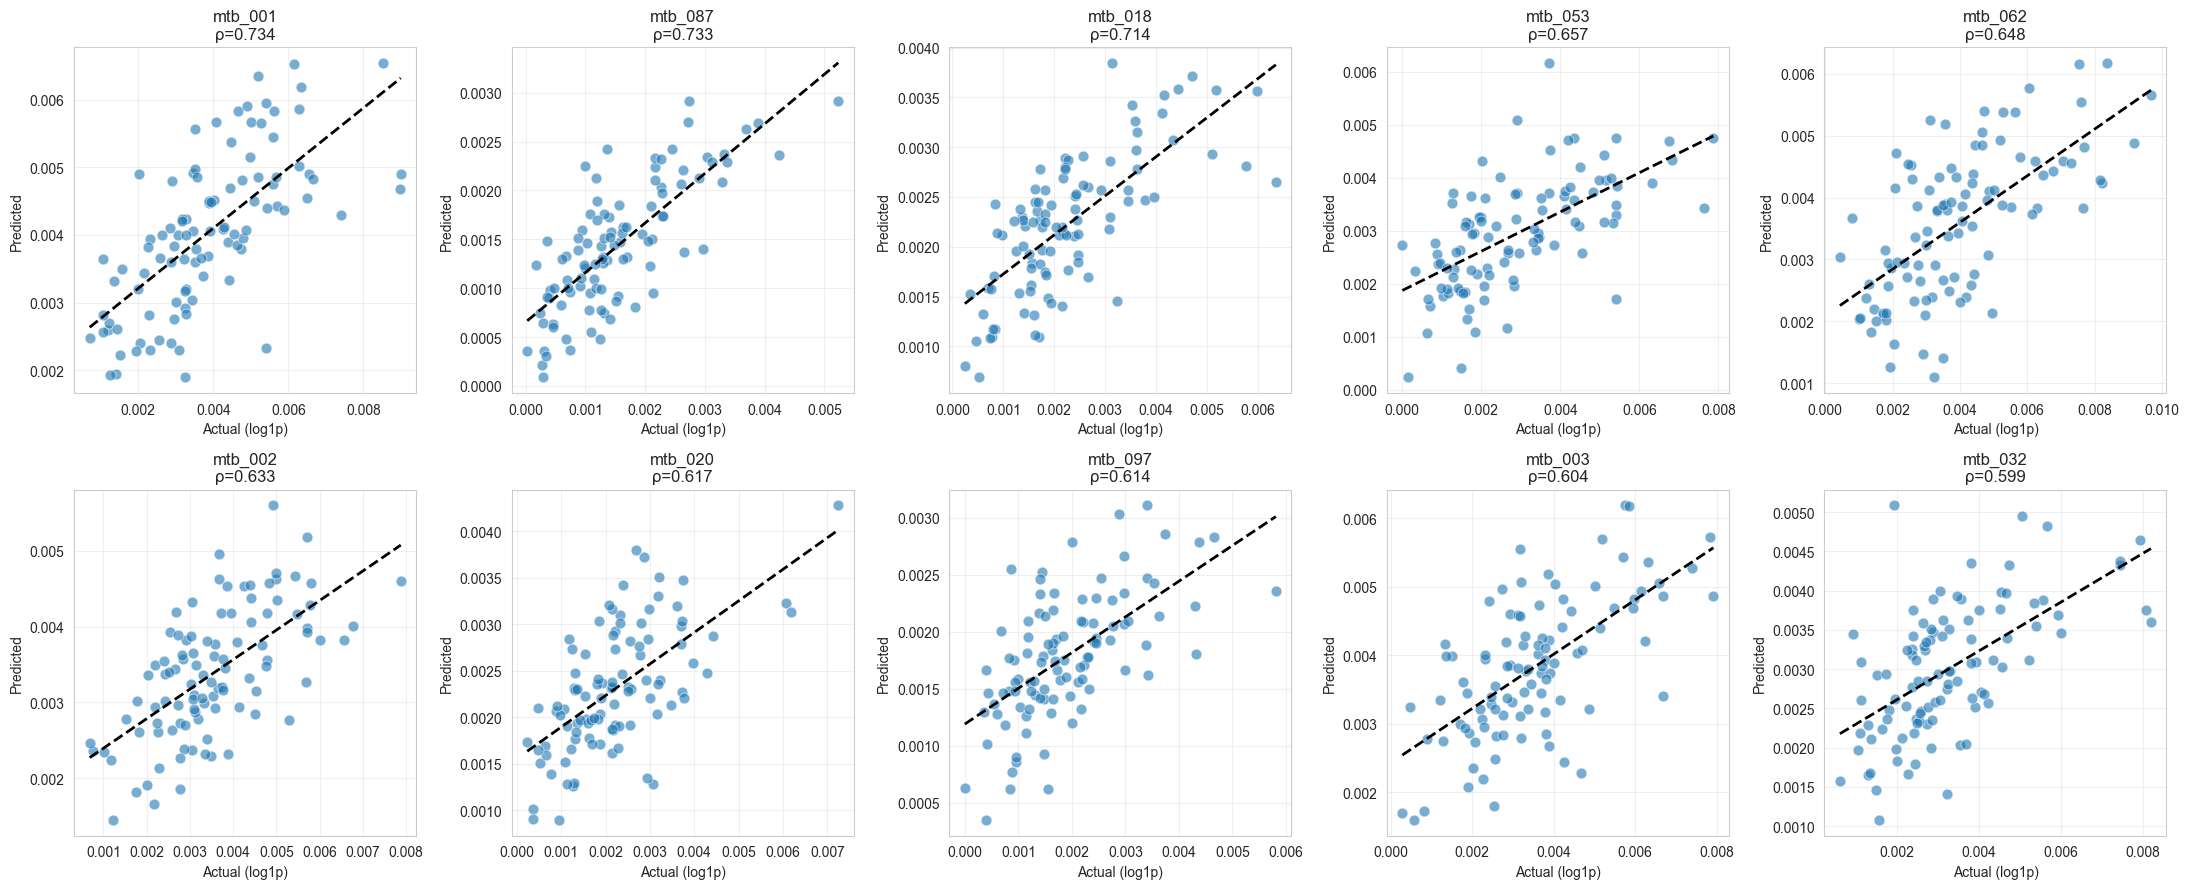

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

top10 = df_rho.head(10)

fig, axes = plt.subplots(2, 5, figsize=(22, 9))
axes = axes.flatten()

for i, row in enumerate(top10.itertuples(index=False)):
    name = row.Metabolite
    rho = row.Spearman_Rho
    j = met_names.index(name)

    yt = y_test_raw[:, j]
    yp = pred_test[:, j]

    ax = axes[i]
    sns.scatterplot(x=yt, y=yp, ax=ax, alpha=0.6, s=60, edgecolor="w")
    slope, intercept, *_ = linregress(yt, yp)
    xr = np.array([yt.min(), yt.max()])
    ax.plot(xr, slope*xr + intercept, "k--", lw=2)
    ax.set_title(f"{name}\nρ={rho:.3f}")
    ax.set_xlabel("Actual (log1p)")
    ax.set_ylabel("Predicted")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
